## **OFA**
Start to enjoy visual grounding with OFA! 

## **Download Checkpoint**
We provide a link for our public checkpoint, and you only need to wget it to your workspace. We also provide an alternative below. Choose one as you like!

## **Install Fairseq**
We advise you to install fairseq by cloning the official repository and running "pip install". 

You should restart the window if you meet the hint of "RESTART RUNTIME". 

## **Preparation**
Below you just need to import required packages, and check whether to use GPU or FP16. 

In [1]:
import torch
import numpy as np
from fairseq import utils, tasks
from fairseq import checkpoint_utils
from utils.eval_utils import eval_step
from tasks.mm_tasks.refcoco import RefcocoTask
from models.ofa import OFAModel
from PIL import Image
import os

os.environ["CUDA_VISIBLE_DEVICES"]="2,3,5"

# Register refcoco task
tasks.register_task('refcoco', RefcocoTask)

# turn on cuda if GPU is available
use_cuda = torch.cuda.is_available()
# use fp16 only when GPU is available
use_fp16 = False

/home/jhkim/anaconda3/envs/ofa/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## **Build Model**
Below you can build your model and load the weights from the given checkpoint, and also build a generator. 

In [2]:
# Load pretrained ckpt & config
overrides={"bpe_dir":"utils/BPE"}

model_path1 = '/data/jhkim/icra24/ofa_checkpoints/propagation_ignore/checkpoint_best.pt'
model_path2 = '/data/jhkim/icra24/ofa_checkpoints/propagation_ignore_from2/checkpoint_best.pt'

models1, cfg, task = checkpoint_utils.load_model_ensemble_and_task(
        utils.split_paths(model_path1),
        arg_overrides=overrides
    )

models2, cfg, task = checkpoint_utils.load_model_ensemble_and_task(
        utils.split_paths(model_path2),
        arg_overrides=overrides
    )

cfg.common.seed = 7
cfg.generation.beam = 5
cfg.generation.min_len = 4
cfg.generation.max_len_a = 0
cfg.generation.max_len_b = 4
cfg.generation.no_repeat_ngram_size = 3

# Fix seed for stochastic decoding
if cfg.common.seed is not None and not cfg.generation.no_seed_provided:
    np.random.seed(cfg.common.seed)
    utils.set_torch_seed(cfg.common.seed)

# Move models to GPU
for model in models1:
    model.eval()
    if use_fp16:
        model.half()
    if use_cuda and not cfg.distributed_training.pipeline_model_parallel:
        model.cuda()
    model.prepare_for_inference_(cfg)

for model in models2:
    model.eval()
    if use_fp16:
        model.half()
    if use_cuda and not cfg.distributed_training.pipeline_model_parallel:
        model.cuda()
    model.prepare_for_inference_(cfg)

# Initialize generator
generator1 = task.build_generator(models1, cfg.generation)
generator2 = task.build_generator(models2, cfg.generation)

2023-08-21 12:27:37 | INFO | tasks.ofa_task | source dictionary: 59457 types
2023-08-21 12:27:37 | INFO | tasks.ofa_task | target dictionary: 59457 types
2023-08-21 12:28:32 | INFO | tasks.ofa_task | source dictionary: 59457 types
2023-08-21 12:28:32 | INFO | tasks.ofa_task | target dictionary: 59457 types


## **Preprocess**
We demonstrate the required transformation fucntions for preprocessing inputs.

In [3]:
# Image transform
from torchvision import transforms
mean = [0.5, 0.5, 0.5]
std = [0.5, 0.5, 0.5]

patch_resize_transform = transforms.Compose([
    lambda image: image.convert("RGB"),
    transforms.Resize((cfg.task.patch_image_size, cfg.task.patch_image_size), interpolation=Image.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std),
])

# Text preprocess
bos_item = torch.LongTensor([task.src_dict.bos()])
eos_item = torch.LongTensor([task.src_dict.eos()])
pad_idx = task.src_dict.pad()
def encode_text(text, length=None, append_bos=False, append_eos=False):
    s = task.tgt_dict.encode_line(
        line=task.bpe.encode(text.lower()),
        add_if_not_exist=False,
        append_eos=False
    ).long()
    if length is not None:
        s = s[:length]
    if append_bos:
        s = torch.cat([bos_item, s])
    if append_eos:
        s = torch.cat([s, eos_item])
    return s

# Construct input for refcoco task
patch_image_size = cfg.task.patch_image_size
def construct_sample(image: Image, text: str):
    w, h = image.size
    w_resize_ratio = torch.tensor(patch_image_size / w).unsqueeze(0)
    h_resize_ratio = torch.tensor(patch_image_size / h).unsqueeze(0)
    patch_image = patch_resize_transform(image).unsqueeze(0)
    patch_mask = torch.tensor([True])
    src_text = encode_text(' which region does the text " {} " describe?'.format(text), append_bos=True, append_eos=True).unsqueeze(0)
    src_length = torch.LongTensor([s.ne(pad_idx).long().sum() for s in src_text])
    sample = {
        "id":np.array(['42']),
        "net_input": {
            "src_tokens": src_text,
            "src_lengths": src_length,
            "patch_images": patch_image,
            "patch_masks": patch_mask,
        },
        "w_resize_ratios": w_resize_ratio,
        "h_resize_ratios": h_resize_ratio,
        "region_coords": torch.randn(1, 4)
    }
    return sample
  
# Function to turn FP32 to FP16
def apply_half(t):
    if t.dtype is torch.float32:
        return t.to(dtype=torch.half)
    return t

/home/jhkim/anaconda3/envs/ofa/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  
/home/jhkim/anaconda3/envs/ofa/lib/python3.7/site-packages/torchvision/transforms/transforms.py:281: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


## **Run Inference**
Download an image and run the following scripts to generate the result.

In [4]:
import torch
test_path = '/data/jhkim/icra24/ofa_vg_data/test_annotation/seen_random.pth'
answer = torch.load(test_path)

In [5]:
# image = Image.open('/data/jhkim/icra24/raw_images/test/seen_random/0.png')
# image = image.crop((0,150,image.size[0],image.size[1]))
# text = "object" 
q = 4
image = Image.open('/data/jhkim/icra24/raw_images/test/seen_random/{}'.format(answer[q][0]))
text = answer[q][2]
gt_box = answer[q][3]
# Construct input sample & preprocess for GPU if cuda available
sample = construct_sample(image, text)
sample = utils.move_to_cuda(sample) if use_cuda else sample

# Run eval step for refcoco
with torch.no_grad():
    result, scores = eval_step(task, generator2, models2, sample)

/home/jhkim/anaconda3/envs/ofa/lib/python3.7/site-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  ../aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)


1.png
my plushie, Ruby


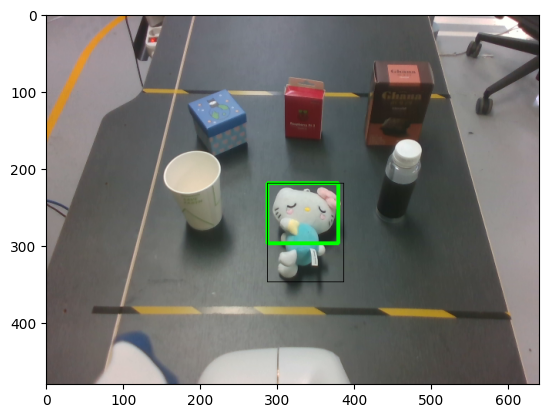

In [6]:
import cv2
import numpy

img = cv2.cvtColor(numpy.asarray(image), cv2.COLOR_RGB2BGR)
cv2.rectangle(
    img,
    (int(result[0]["box"][0]), int(result[0]["box"][1])),
    (int(result[0]["box"][2]), int(result[0]["box"][3])),
    (0, 255, 0),
    3
)

cv2.rectangle(
    img,
    (int(gt_box[0]), int(gt_box[1])),
    (int(gt_box[2]), int(gt_box[3])),
    (0, 0, 0),
    1
)
#print(result[0]["box"])

from matplotlib import pyplot as plt
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
print(answer[q][0])
print(text)

# Evaluation Code

In [7]:
def IoU(box1, box2):
    # box = (x1, y1, x2, y2)
    box1_area = (box1[2] - box1[0] + 1) * (box1[3] - box1[1] + 1)
    box2_area = (box2[2] - box2[0] + 1) * (box2[3] - box2[1] + 1)

    # obtain x1, y1, x2, y2 of the intersection
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])

    # compute the width and height of the intersection
    w = max(0, x2 - x1 + 1)
    h = max(0, y2 - y1 + 1)

    inter = w * h
    iou = inter / (box1_area + box2_area - inter)
    return iou

In [8]:
import cv2
import numpy
import json

testsplits = ['seen_random', 'seen_same', 'unseen_random', 'unseen_same', 'cluttered']

results_save_path = '/data/jhkim/icra24/qualitative/all_wrong'

seen_random_candidates = {}
seen_same_candidates = {}
unseen_random_candidates = {}
unseen_same_candidates = {}
cluttered_candidates = {}

for split in testsplits:
    test_path = '/data/jhkim/icra24/ofa_vg_data/test_annotation/{}.pth'.format(split)
    answer = torch.load(test_path)
    yes_cnt_5 = 0
    for i, anw in enumerate(answer):
        image = Image.open('/data/jhkim/icra24/raw_images/test/{}/{}'.format(split,anw[0]))
        text = anw[2] 

        # Construct input sample & preprocess for GPU if cuda available
        sample = construct_sample(image, text)
        sample = utils.move_to_cuda(sample) if use_cuda else sample
        sample = utils.apply_to_sample(apply_half, sample) if use_fp16 else sample
        with torch.no_grad():
            result1, scores1 = eval_step(task, generator1, models1, sample)
            result2, scores2 = eval_step(task, generator2, models2, sample)
        
        if IoU(result2[0]['box'], anw[3]) < 0.8:
            if IoU(result1[0]['box'], anw[3]) < 0.5:
                yes_cnt_5 += 1
                if text in globals()['{}_candidates'.format(split)].keys():
                    globals()['{}_candidates'.format(split)][text].append(anw[0])
                else:
                    globals()['{}_candidates'.format(split)][text] = [anw[0]]
                
                gt_box = anw[3]

                img = numpy.asarray(image)
                cv2.rectangle(
                    img,
                    (int(result1[0]["box"][0]), int(result1[0]["box"][1])),
                    (int(result1[0]["box"][2]), int(result1[0]["box"][3])),
                    (255, 0, 0),
                    3
                )

                cv2.rectangle(
                    img,
                    (int(result2[0]["box"][0]), int(result2[0]["box"][1])),
                    (int(result2[0]["box"][2]), int(result2[0]["box"][3])),
                    (0, 0, 255),
                    3
                )

                cv2.rectangle(
                    img,
                    (int(gt_box[0]), int(gt_box[1])),
                    (int(gt_box[2]), int(gt_box[3])),
                    (0, 0, 0),
                    2
                )
                #print(result[0]["box"])

                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                cv2.imwrite(os.path.join(results_save_path,'{}_{}.png'.format(split,yes_cnt_5)),img)
                print(anw[0])
                print(text)
                print('---------------------------------')

    print("{}: {}".format(split,yes_cnt_5))

    path = './qualitative_results/{}_candidates.json'.format(split)
    with open(path, 'w') as fp:
        json.dump(globals()['{}_candidates'.format(split)], fp)


4.png
my brother's glasses case
---------------------------------
8.png
my Iron Man pencil case
---------------------------------
10.png
Canadian maple syrup
---------------------------------
14.png
my uncle's AirPods pro
---------------------------------
seen_random: 4
0.png
an expensive mouse for the television
---------------------------------
1.png
the charger for my brand new MacBook
---------------------------------
6.png
my brother's glasses case
---------------------------------
8.png
the hairbrush that I use when curling my hair
---------------------------------
9.png
the remote for air conditioner
---------------------------------
11.png
Lent lily
---------------------------------
14.png
my Iron Man pencil case
---------------------------------
19.png
pills for headaches
---------------------------------
20.png
pills for toddlers seizure
---------------------------------
21.png
Canadian maple syrup 
---------------------------------
22.png
a nourishing hand cream
------------

In [9]:
random_set = set(seen_random_candidates.keys()) | set(unseen_random_candidates.keys())
same_set = set(seen_same_candidates.keys()) | set(unseen_same_candidates.keys())

inter = random_set & same_set
inter = list(inter)

In [10]:
inter

['the remote controller for the living room speaker',
 "my brother's glasses case",
 'my Iron Man pencil case',
 'the teddy bear I made']

In [11]:
# import torch
# import os

# os.environ["CUDA_VISIBLE_DEVICES"]="2,3,4,5"

# pga_nodes_path = '/data/jhkim/icra24/ofa_vg_data/lp_vanilla_0.55_400sampled_ignore_from2.pth'
# passive_nodes_path = '/data/jhkim/icra24/ofa_vg_data/lp_vanilla_0.55_400sampled_ignore_inter.pth'

# pga_nodes = torch.load(pga_nodes_path, map_location="cuda:0")
# # passive_nodes = torch.load(passive_nodes_path, map_location="cuda:1")


# import shutil

# objects_path = '/data/jhkim/icra24/cropped_objects'

# passive_save_path = '/data/jhkim/icra24/propagated_imgs/passive'
# passive_wrong_save_path = '/data/jhkim/icra24/propagated_imgs/passive_wrong'
# passive_missed_save_path = '/data/jhkim/icra24/propagated_imgs/passive_missed'
# pga_save_path = '/data/jhkim/icra24/propagated_imgs/PGA'
# pga_wrong_save_path = '/data/jhkim/icra24/propagated_imgs/PGA_wrong'
# pga_missed_save_path = '/data/jhkim/icra24/propagated_imgs/PGA_missed'

# for node in pga_nodes:
#     if not node['interaction']:
#         label = node['label']
#         gt = node['category']
#         img_id = node['img_id']
#         obj_id = node['object_id']
#         save_png_name = img_id.split('.')[0] + '_' + obj_id
#         source_path = os.path.join(objects_path, img_id, obj_id)

#         if node['labelled'] == True:
#             if label == gt:
#                 path = os.path.join(pga_save_path,label)
#                 if not os.path.exists(path):
#                     os.makedirs(path)
#             else:
#                 path = os.path.join(pga_wrong_save_path,label)
#                 if not os.path.exists(path):
#                     os.makedirs(path)
#                 path2 = os.path.join(pga_missed_save_path, gt)
#                 if not os.path.exists(path2):
#                     os.makedirs(path2)
#         else:
#             path = os.path.join(pga_missed_save_path, gt)
#             if not os.path.exists(path):
#                 os.makedirs(path)
#         path = os.path.join(path, save_png_name)
#         shutil.copy2(source_path, path)    

# # for node in passive_nodes:
# #     if not node['interaction']:
# #         label = node['label']
# #         gt = node['category']
# #         img_id = node['img_id']
# #         obj_id = node['object_id']
# #         save_png_name = img_id.split('.')[0] + '_' + obj_id
# #         source_path = os.path.join(objects_path, img_id, obj_id)

# #         if node['labelled']:
# #             if label == gt:
# #                 path = os.path.join(passive_save_path,label)
# #                 if not os.path.exists(path):
# #                     os.makedirs(path)
# #             else:
# #                 path = os.path.join(passive_wrong_save_path,label)
# #                 if not os.path.exists(path):
# #                     os.makedirs(path)
# #                 path2 = os.path.join(passive_missed_save_path, gt)
# #                 if not os.path.exists(path2):
# #                     os.makedirs(path2)
# #         else:
# #             path = os.path.join(passive_missed_save_path, gt)
# #             if not os.path.exists(path):
# #                 os.makedirs(path)
# #         path = os.path.join(path, save_png_name)
# #         shutil.copy2(source_path, path)